# Modules

In [1]:
%%capture
!pip install sunpy
!pip install zeep
!pip install drms
!pip install Glymur

In [2]:
import sys,time,pickle,warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import numpy as np
import numpy.ma as ma

In [4]:
from math import degrees
from itertools import cycle,islice
from scipy.stats import linregress
from astropy.utils.exceptions import AstropyWarning

In [5]:
from skimage.filters import median
from skimage.morphology import disk,square,white_tophat
from skimage.util import invert

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [30]:
import sunpy.map
import astropy.units as u
from sunpy.net import attrs as a
from sunpy.net import Fido

In [8]:
warnings.simplefilter("ignore",category=AstropyWarning)

In [9]:
plt.style.use("dark_background")
%matplotlib inline

# Morphological Operation

In [184]:
def MorphologicalOperation(smap,circleRadius:u.deg=100*u.arcsec,medianBox:u.deg=10*u.arcsec,threshold:int=6000,limFilter:u.percent=None)->bool:
  data = invert(smap.data)
  # Filter things that are close to limb to reduce false detections
  if limFilter is not None:
    coords = sunpy.map.all_coordinates_from_map(smap)
    distance = np.sqrt(coords.Tx**2+coords.Ty**2)/(smap.rsun_obs-smap.rsun_obs*limFilter)
    data[distance>1] = np.nan
  # Median filter to remove detections based on hot pixels
  pixels = int((medianBox/smap.scale[0]).to_value(u.pix))
  medianPoint = median(data,square(pixels),behavior="ndimage")
  # Construct the pixel structuring element
  pixelStructure = int((circleRadius/smap.scale[0]).to_value(u.pix))
  circle = disk(pixelStructure/2)
  # Filter out nans
  topHat = white_tophat(medianPoint,circle)
  topHat[np.isnan(topHat)] = 0
  return topHat>threshold

# Before Project

## DBSCAN: Density-Based Spatial Clustering of Applications with Noise

* DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It's a popular clustering algorithm that's particularly good at identifying clusters of varying shapes and sizes, and it's robust to outliers.

**Logic of DBSCAN**:
  - Core Points: In DBSCAN, a core point is a point that has a minimum number of other points (MinPts) within a given radius (ε, epsilon).

  - Border Points: A border point is not a core point, but falls within the radius ε of a core point.

  - Noise: A point that is neither a core nor a border point is considered noise.

  - Clusters Formation: The algorithm starts by picking an arbitrary point. If this point is a core point, a cluster is expanded by adding all directly reachable points. This process continues recursively, leading to the growth of the cluster.

  - Handling Noise: Points that are not reachable from any core points are labeled as noise and usually ignored in further analysis.

  - Stop Criteria: The process continues until all points are either assigned to a cluster or marked as noise.

In [10]:
from sklearn.datasets import make_blobs

In [11]:
# used to generate a sample dataset with blob-shaped clusters
x,_ = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=0.6,
    random_state=0
)

In [12]:
len(x)

300

In [13]:
epsilon = 0.3 # the radius of neighborhood

In [14]:
minNumber = 5 # minimum number of points to form a dense region

In [15]:
dbs = DBSCAN(eps=epsilon,min_samples=minNumber)
# assigns each sample to a cluster or marks it as noise
clusters = dbs.fit_predict(x)

In [16]:
len(clusters)

300

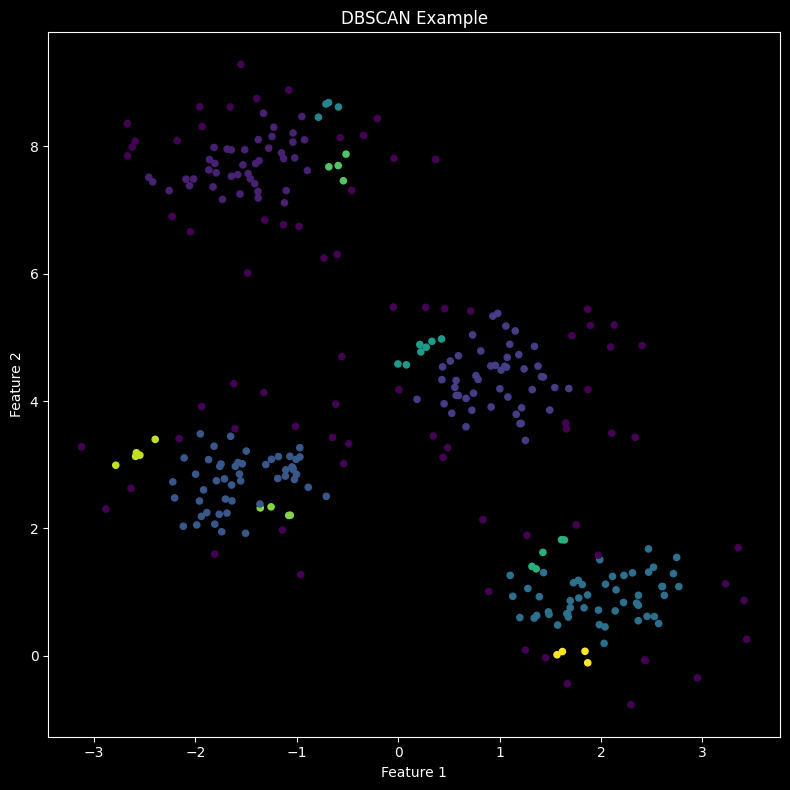

In [17]:
plt.figure(figsize=(8,8))
plt.title("DBSCAN Example")
plt.scatter(x[:,0],x[:,1],s=20,c=clusters,cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()

## Disk - Square - White_tophat

**The Functions and Objects**:

- disk: Creates a disk-shaped structuring element. This shape is often used in morphological operations like dilation or erosion. The size of the disk is specified by its radius.

- square: Creates a square-shaped structuring element. Similar to disk, it's used in morphological operations, and its size is defined by the length of the square's side.

- white_tophat: Performs a white top-hat transformation on an image. This operation is used to highlight small, bright objects on a dark background. It is defined as the difference between the input image and its opening by some structuring element.

In [18]:
from skimage import data,img_as_float
from skimage.color import rgb2gray

In [19]:
# Load an example image
exampleImage = img_as_float(rgb2gray(data.coffee()))

In [20]:
diskElement = disk(10) # disk with radius 10
squareElement = square(25) # square with side length 25

In [21]:
#diskElement

In [22]:
#squareElement

In [23]:
# Apply white top-hat transformation
whiteTopHatDisk = white_tophat(exampleImage,diskElement)
whiteTopHatSquare = white_tophat(exampleImage,squareElement)

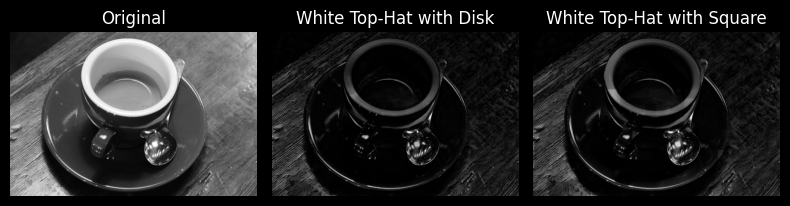

In [24]:
figure,axs = plt.subplots(1,3,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(exampleImage,cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(whiteTopHatDisk,cmap="gray")
ax[1].set_title("White Top-Hat with Disk")
ax[2].imshow(whiteTopHatSquare,cmap="gray")
ax[2].set_title("White Top-Hat with Square")
for a in ax:
  a.axis("off")
plt.tight_layout()
plt.show()

## Invert

* This function is used for image processing and it inverts the intensity of the pixels in an image.

* The inversion of an image, sometimes called negative image, is a basic image processing operation where each pixel's intensity is transformed to its inverse within the allowed range of values. If I is the original intensity of a pixel, the inverted intensity I' is calculated as:
  - For an 8-bit image (values ranging from 0 to 255): I' = 255 - I
  - For a binary image (values 0 and 1): I' = 1 - I
  - For a floating-point image (values typically between 0.0 and 1.0): I' = 1.0 - I

In [25]:
exampleImage = img_as_float(rgb2gray(data.astronaut()))

In [26]:
invertedExampleImage = invert(exampleImage)

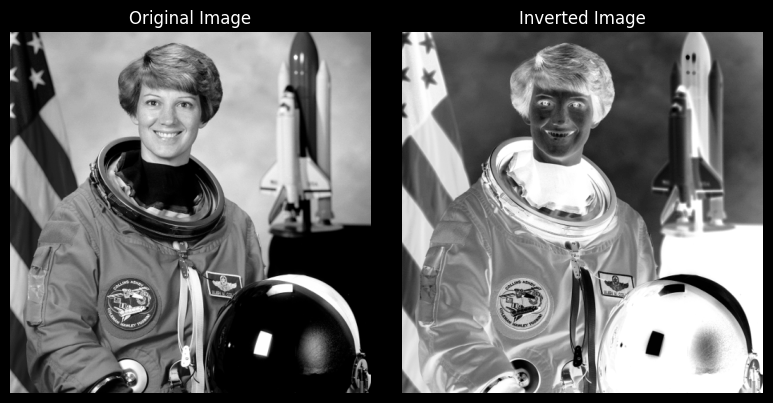

In [27]:
fig,axes = plt.subplots(1,2,figsize=(8,4))
ax = axes.ravel()
ax[0].imshow(exampleImage,cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(invertedExampleImage,cmap='gray')
ax[1].set_title('Inverted Image')
for axIndex in ax:
  axIndex.axis('off')
plt.tight_layout()
plt.show()

## Median

* The median filter works by moving through the image pixel by pixel, replacing each value with the median value of neighboring pixels. The neighborhood is defined by a structuring element, which determines the shape and size of the region around each pixel over which the median is computed.

**The main steps are**:

  - Choose a Window Size: The size of the structuring element (like a square of 3x3, 5x5 pixels, etc.) is selected. This determines the number of neighboring pixels to consider.

  - Slide Over Image: The filter window slides across the image, one pixel at a time.

  - Compute Median: For each position of the window, the median of the intensity values within the window is calculated.

  - Replace Pixel: The pixel value at the center of the window is replaced with this median value.

  - Edge Handling: At the edges of the image, where the window might extend beyond the image boundaries, various strategies (like padding) can be used to handle this.

In [46]:
from skimage import util

In [45]:
exampleImage = img_as_float(data.camera())

In [52]:
noisyImage = util.random_noise(exampleImage,mode="s&p",amount=0.15)

In [53]:
diskElement = disk(3) # disk with radius 3

In [57]:
diskElement

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

In [56]:
diskElement.shape

(7, 7)

In [54]:
filteredImage = median(noisyImage,diskElement)

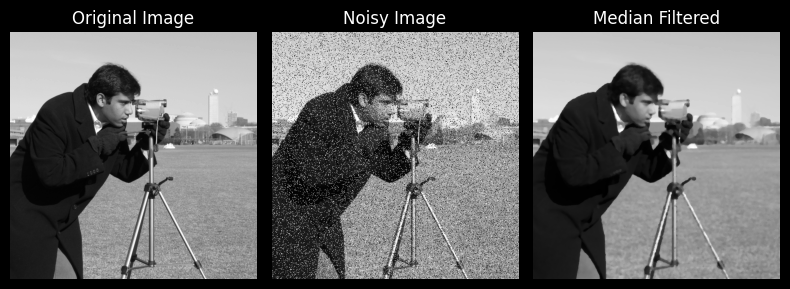

In [55]:
figure,axs = plt.subplots(1,3,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(exampleImage,cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(noisyImage,cmap="gray")
ax[1].set_title("Noisy Image")
ax[2].imshow(filteredImage,cmap="gray")
ax[2].set_title("Median Filtered")
for axIndex in ax:
  axIndex.axis("off")
plt.tight_layout()
plt.show()

## Example with Real Data - Based On Project

In [60]:
dataSearch = Fido.search(
    a.Time("2023/01/01 12:00","2023/01/02 12:00"),
    a.Instrument("HMI"),
    a.Sample(0.5*u.day),
    a.Physobs("intensity")
)

In [61]:
dataSearch

<sunpy.net.fido_factory.UnifiedResponse object at 0x7f83459e4790>
Results from 1 Provider:

2 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2023-01-01 12:00:22.000 2023-01-01 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-02 00:00:22.000 2023-01-02 00:00:23.000    SDO ...    FULLDISK -0.00098

In [62]:
filesExample = Fido.fetch(dataSearch,path="/content/imagesBeforeProject")
filesExample = sorted(filesExample)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

hmi_ic_45s_2023_01_02_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_01_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

In [63]:
filesExample

['/content/imagesBeforeProject/hmi_ic_45s_2023_01_01_12_01_30_tai_continuum.fits',
 '/content/imagesBeforeProject/hmi_ic_45s_2023_01_02_00_01_30_tai_continuum.fits']

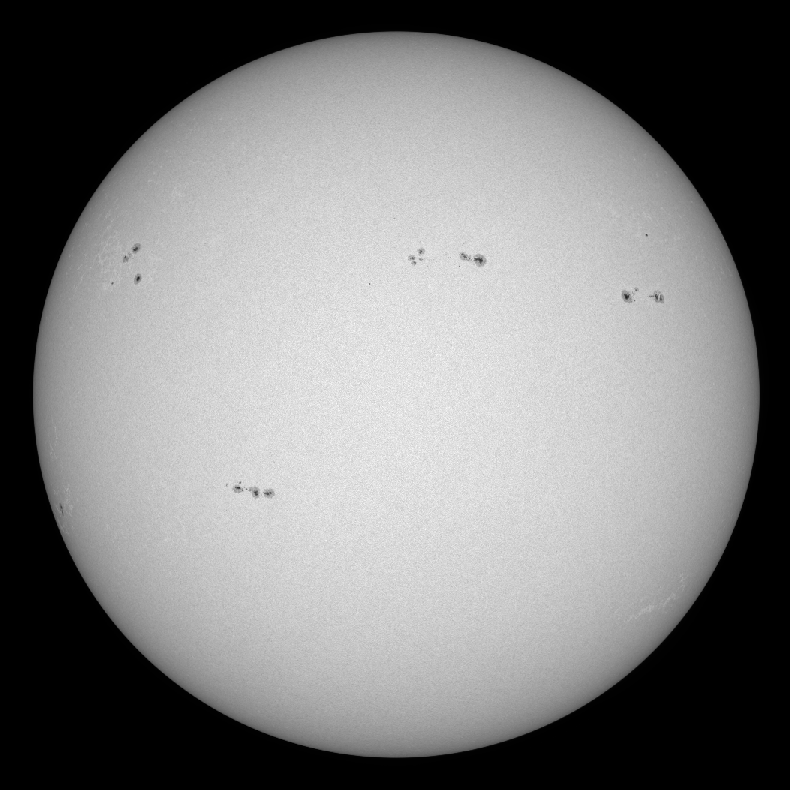

In [64]:
smap = sunpy.map.Map(filesExample[0])
smap = smap.resample((1024,1024)*u.pix)
figure = plt.figure(1,figsize=(8,8))
axs = figure.add_subplot(projection=smap)
axs.set_axis_off()
rot = smap.rotate(order=3)
rot.plot(axes=axs,annotate=False)
plt.tight_layout()
plt.show()

In [65]:
imageData = smap.data

In [66]:
inverData = invert(imageData)

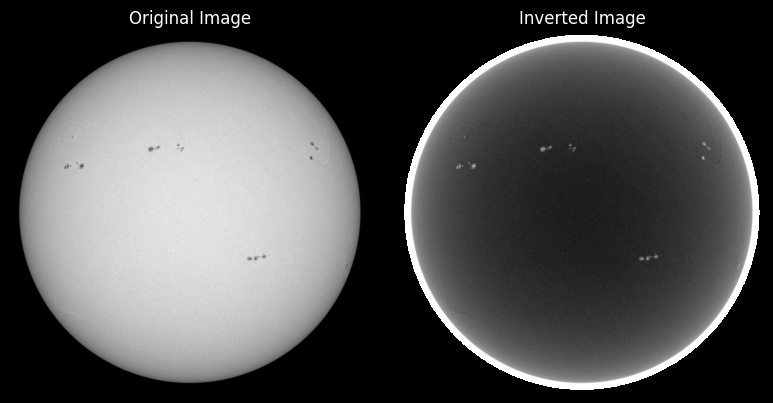

In [67]:
fig,axes = plt.subplots(1,2,figsize=(8,4))
ax = axes.ravel()
ax[0].imshow(imageData,cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(inverData,cmap='gray')
ax[1].set_title('Inverted Image')
for axIndex in ax:
  axIndex.axis('off')
plt.tight_layout()
plt.show()

In [68]:
allCoordinates = sunpy.map.all_coordinates_from_map(smap)

In [70]:
smap.rsun_obs

<Quantity 975.80188 arcsec>

In [71]:
smap.rsun_obs*5*u.percent

<Quantity 4879.0094 arcsec %>

In [72]:
smap.rsun_obs-smap.rsun_obs*5*u.percent

<Quantity 927.011786 arcsec>

In [ ]:
#allCoordinates.Tx

In [ ]:
#allCoordinates.Ty

In [141]:
distance = np.sqrt(allCoordinates.Tx**2+allCoordinates.Ty**2)/(smap.rsun_obs-smap.rsun_obs*5*u.percent)

In [142]:
inverData[distance > 1] = np.nan

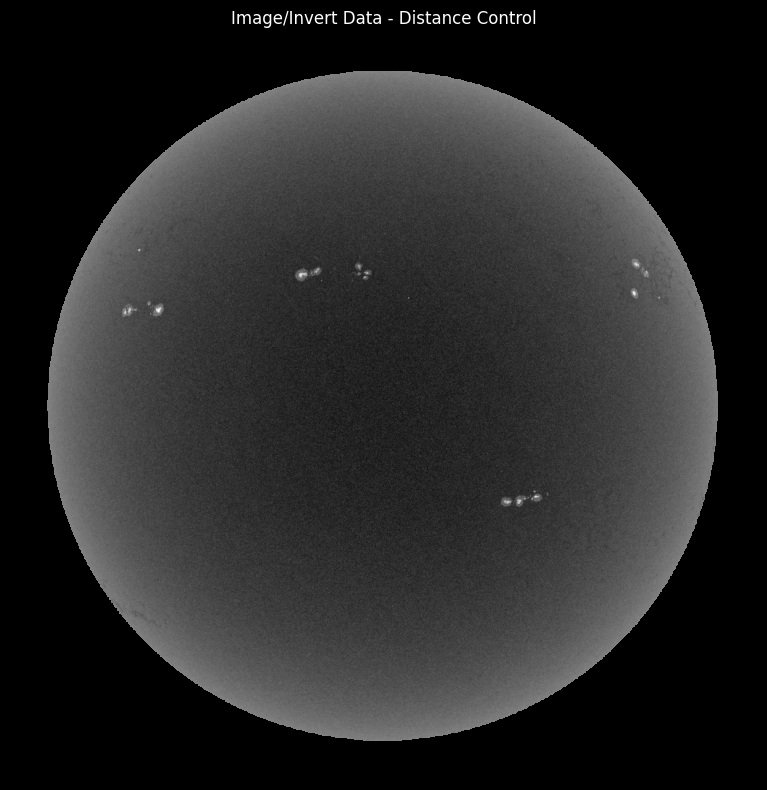

In [143]:
plt.figure(figsize=(8,8))
plt.title("Image/Invert Data - Distance Control")
plt.axis("off")
plt.imshow(inverData,cmap="gray")
plt.tight_layout()
plt.show()

In [144]:
medianValue = 10*u.arcsec

In [145]:
medianValue

<Quantity 10. arcsec>

In [146]:
smap.scale[0]

<Quantity 2.016124 arcsec / pix>

In [147]:
pixels = int((medianValue/smap.scale[0]).to_value(u.pix))

In [148]:
pixels

4

In [149]:
shapeElement = square(pixels)

In [150]:
shapeElement.shape

(4, 4)

In [151]:
medianFilteredImage = median(inverData,shapeElement,behavior="ndimage")

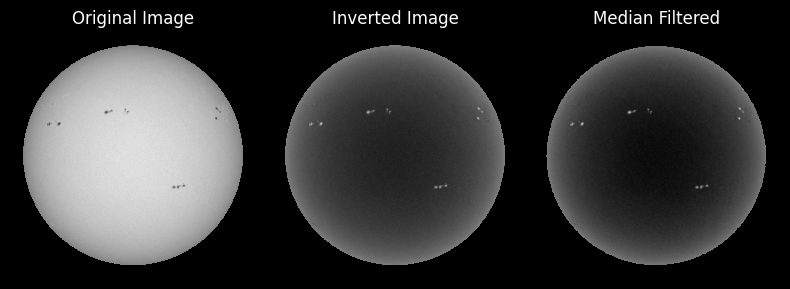

In [152]:
figure,axs = plt.subplots(1,3,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(imageData,cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(inverData,cmap="gray")
ax[1].set_title("Inverted Image")
ax[2].imshow(medianFilteredImage,cmap="gray")
ax[2].set_title("Median Filtered")
for axIndex in ax:
  axIndex.axis("off")
plt.tight_layout()
plt.show()

In [153]:
circleRadius = 100*u.arcsec

In [154]:
circleRadius

<Quantity 100. arcsec>

In [155]:
pixelDistance = int((circleRadius/smap.scale[0]).to_value(u.pix))

In [156]:
pixelDistance

49

In [157]:
pixelDistance/2

24.5

In [158]:
diskStructure = disk(pixelDistance/2)

In [159]:
diskStructure.shape

(50, 50)

In [160]:
whiteTopImage = white_tophat(medianFilteredImage,diskStructure)

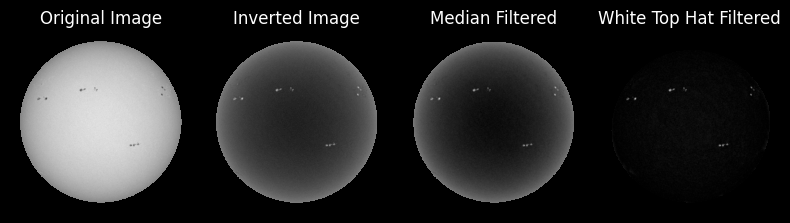

In [161]:
figure,axs = plt.subplots(1,4,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(imageData,cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(inverData,cmap="gray")
ax[1].set_title("Inverted Image")
ax[2].imshow(medianFilteredImage,cmap="gray")
ax[2].set_title("Median Filtered")
ax[3].imshow(whiteTopImage,cmap="gray")
ax[3].set_title("White Top Hat Filtered")
for axIndex in ax:
  axIndex.axis("off")
plt.tight_layout()
plt.show()

In [162]:
whiteTopImage[np.isnan(whiteTopImage)] = 0

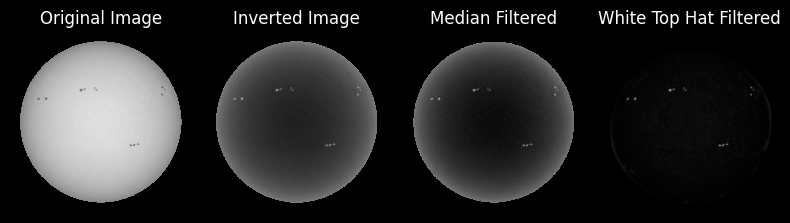

In [163]:
figure,axs = plt.subplots(1,4,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(imageData,cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(inverData,cmap="gray")
ax[1].set_title("Inverted Image")
ax[2].imshow(medianFilteredImage,cmap="gray")
ax[2].set_title("Median Filtered")
ax[3].imshow(whiteTopImage,cmap="gray")
ax[3].set_title("White Top Hat Filtered")
for axIndex in ax:
  axIndex.axis("off")
plt.tight_layout()
plt.show()

In [164]:
threshold = 6000

In [165]:
threshWhiteTop = whiteTopImage > threshold

In [196]:
threshWhiteTop.shape

(1024, 1024)

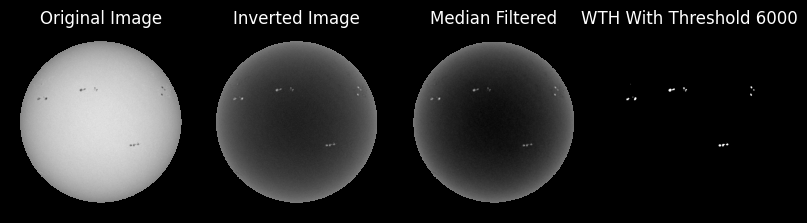

In [166]:
figure,axs = plt.subplots(1,4,figsize=(8,8))
ax = axs.ravel()
ax[0].imshow(imageData,cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(inverData,cmap="gray")
ax[1].set_title("Inverted Image")
ax[2].imshow(medianFilteredImage,cmap="gray")
ax[2].set_title("Median Filtered")
ax[3].imshow(threshWhiteTop,cmap="gray")
ax[3].set_title(f"WTH With Threshold {threshold}")
for axIndex in ax:
  axIndex.axis("off")
plt.tight_layout()
plt.show()

In [185]:
spotBool = MorphologicalOperation(smap,limFilter=5*u.percent)
spots = np.where(spotBool)

In [186]:
spots2D = np.column_stack((spots[0],spots[1]))
clust = DBSCAN(eps=5,min_samples=10).fit(spots2D)
labels = clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [187]:
print('Estimated number of sunspots: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of sunspots: 11
Estimated number of noise points: 6


In [189]:
y_pred = clust.labels_.astype(int)

In [190]:
spots2DRot = threshWhiteTop.shape[0] - spots2D

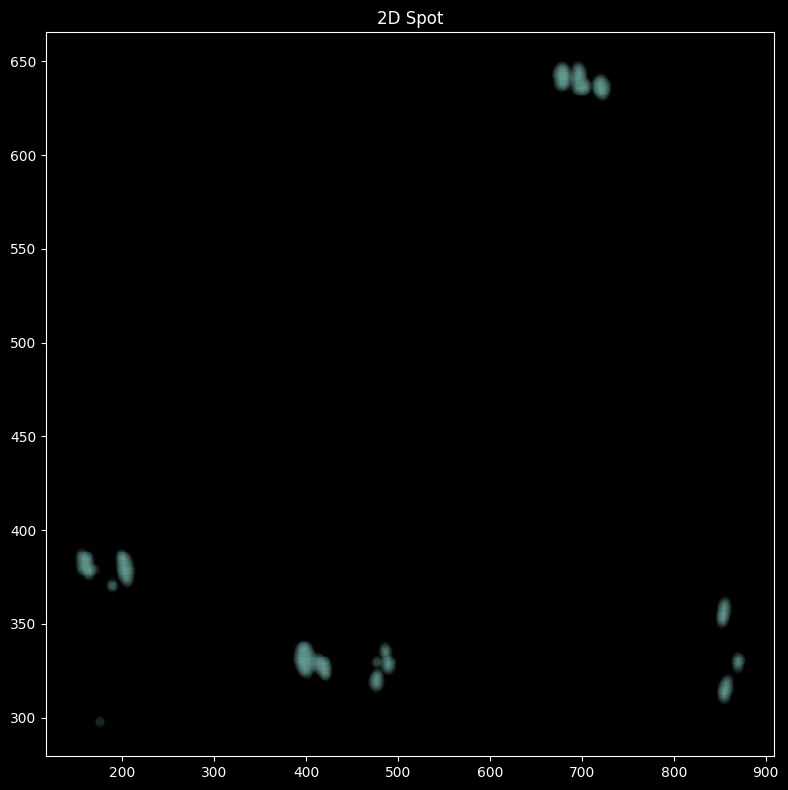

In [191]:
plt.figure(figsize=(8,8))
plt.title("2D Spot")
plt.scatter(spots2DRot[:,1],spots2DRot[:,0],s=30,alpha=0.03)
plt.tight_layout()
plt.show()

In [192]:
def CalculationClusterCenter(spots2DArray,predictions)->np.ndarray:
  clusterPoints = []
  spotStack = np.column_stack((spots2DArray,predictions))
  for index in set(predictions):
    clst = spotStack[np.ix_(spotStack[:,2]==index,(0,1))]
    numberCluster = len(clst)
    xPoint = np.sum(clst[:,0])/numberCluster
    yPoint = np.sum(clst[:,1])/numberCluster
    clusterPoints.append([xPoint,yPoint])
  return np.array(clusterPoints)

In [193]:
clusterPoints = CalculationClusterCenter(spots2D, y_pred)
clusterPointsRot = threshWhiteTop.shape[0] - clusterPoints

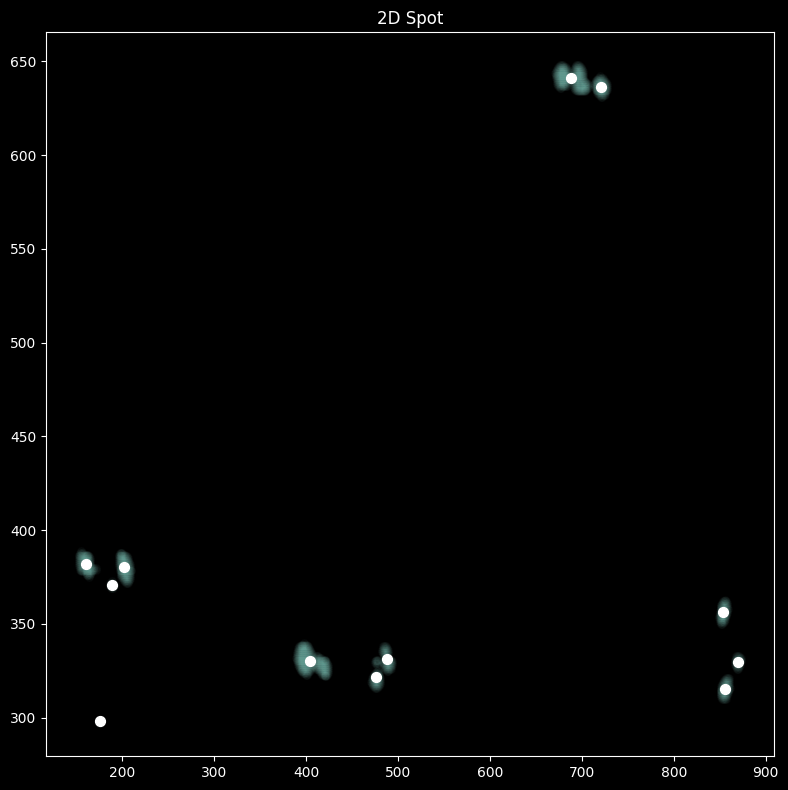

In [194]:
plt.figure(figsize=(8,8))
plt.title("2D Spot")
plt.scatter(spots2DRot[:,1],spots2DRot[:,0],s=30,alpha=0.03)
plt.scatter(clusterPointsRot[:,1],clusterPointsRot[:,0],color="white",s=50)
plt.tight_layout()
plt.show()

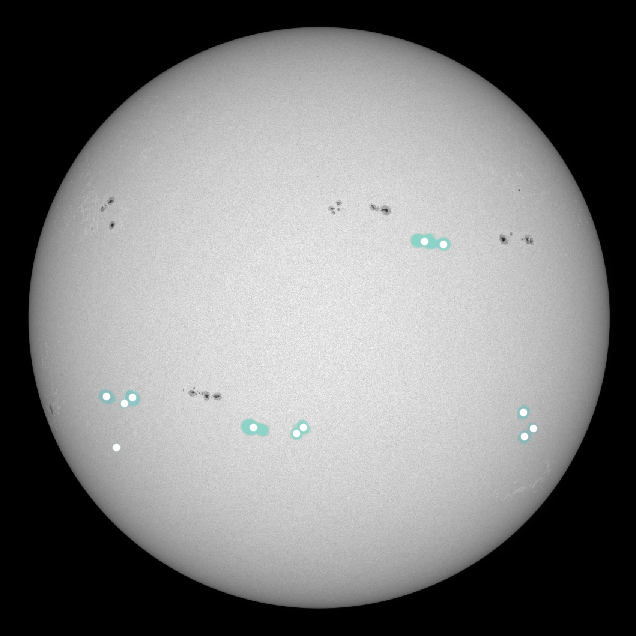

In [195]:
figure2 = plt.figure(figsize=(8,8))
smap = sunpy.map.Map(filesExample[0])
smap = smap.resample((1024,1024)*u.pix)
smap = smap.rotate(order=3)
axs2 = figure2.add_subplot(111,projection=smap)
axs2.scatter(spots2DRot[:,1],spots2DRot[:,0],s=30,alpha=0.03)
axs2.scatter(clusterPointsRot[:,1],clusterPointsRot[:,0],color="white",s=20)
axs2.set_axis_off()
smap.plot(axes=axs2,annotate=False)
plt.show()

# Time Interval Data

In [32]:
timeInterval = a.Time("2023/01/01 12:00","2023/01/09 12:00")
instrument = a.Instrument("HMI")
sample = a.Sample(0.5*u.day)
intensity = a.Physobs("intensity")

In [33]:
dataSearch = Fido.search(
    timeInterval,
    instrument,
    sample,
    intensity
)

In [34]:
dataSearch

<sunpy.net.fido_factory.UnifiedResponse object at 0x7f83465dcfa0>
Results from 1 Provider:

16 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2023-01-01 12:00:22.000 2023-01-01 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-02 00:00:22.000 2023-01-02 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-02 12:00:22.000 2023-01-02 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-03 00:00:22.000 2023-01-03 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-03 12:00:22.000 2023-01-03 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-04 00:00:22.000 2023-01-04 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-04 12:00:22.000 2023-01-04 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-05 00:00:22.000 2023-01-05 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-05 12:00:22.000 2023-01-05 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-06 00:00:22.000 2023-01-06 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-06 12:00:22.000 2023-01-06 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-07 00:00:22.000 2023-01-07 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-07 12:00:22.000 2023-01-07 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-08 00:00:22.000 2023-01-08 00:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-08 12:00:22.000 2023-01-08 12:00:23.000    SDO ...    FULLDISK -0.00098
2023-01-09 00:00:22.000 2023-01-09 00:00:23.000    SDO ...    FULLDISK -0.00098

In [35]:
files = Fido.fetch(dataSearch,path="/content/images")
files = sorted(files)

Files Downloaded:   0%|          | 0/16 [00:00<?, ?file/s]

hmi_ic_45s_2023_01_02_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_01_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_02_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_03_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_03_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_04_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_04_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_05_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_05_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_06_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_06_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_07_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_07_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_08_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_08_12_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

hmi_ic_45s_2023_01_09_00_01_30_tai_continuum.fits:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

In [36]:
files

['/content/images/hmi_ic_45s_2023_01_01_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_02_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_02_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_03_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_03_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_04_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_04_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_05_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_05_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_06_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_06_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_07_00_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_07_12_01_30_tai_continuum.fits',
 '/content/images/hmi_ic_45s_2023_01_08_00_01_30_tai_continuum.fits',
 '/content/images/hm

In [37]:
files = np.asarray(files)
files

array(['/content/images/hmi_ic_45s_2023_01_01_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_02_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_02_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_03_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_03_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_04_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_04_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_05_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_05_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_06_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_06_12_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_07_00_01_30_tai_continuum.fits',
       '/content/images/hmi_ic_45s_2023_01_07_12_01_30_tai_continuum.fits',
       '/con

In [38]:
np.save("/content/files.npy",files)

# Sample Check

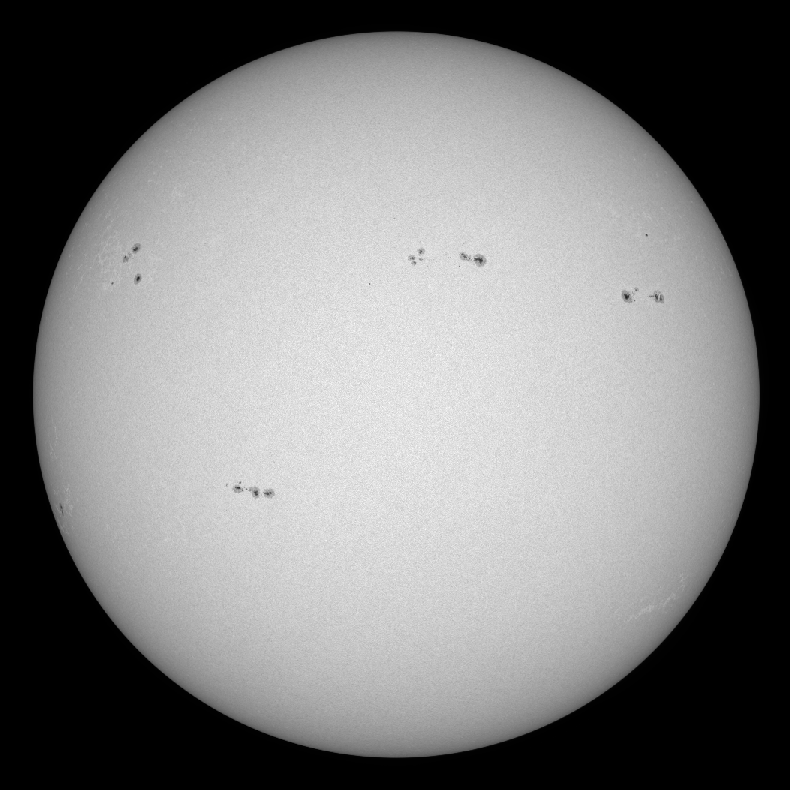

In [39]:
smap = sunpy.map.Map(files[0])
smap = smap.resample((1024,1024)*u.pix)
figure = plt.figure(1,figsize=(8,8))
axs = figure.add_subplot(projection=smap)
axs.set_axis_off()
rot = smap.rotate(order=3)
rot.plot(axes=axs,annotate=False)
plt.tight_layout()
plt.show()

In [40]:
sequences = sunpy.map.Map("./images/*.fits",sequence=True)

In [41]:
len(sequences)

16

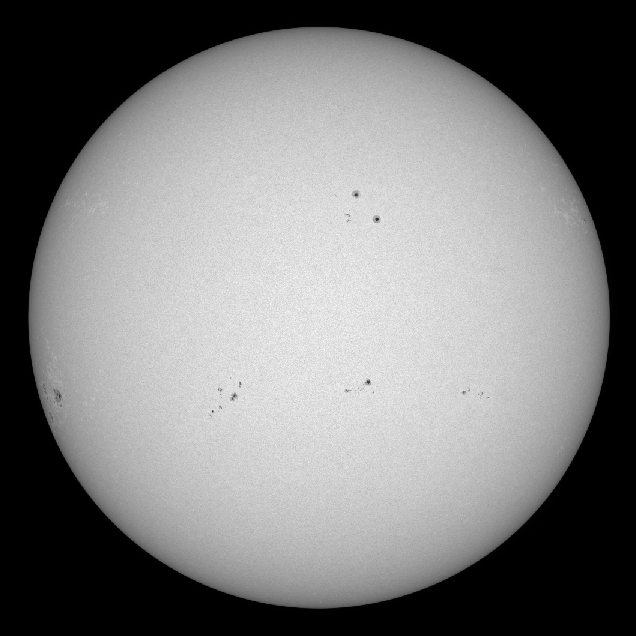

In [42]:
figure2 = plt.figure(len(sequences),figsize=(8,8))
smap = sunpy.map.Map(sequences[9])
smap = smap.resample((1024,1024)*u.pix)
smap = smap.rotate(order=3)
axs2 = figure2.add_subplot(111,projection=smap)
axs2.set_axis_off()
smap.plot(axes=axs2,annotate=False)
plt.show()

Animating frame:0 of Total sequences:16
Animating frame:0 of Total sequences:16
Animating frame:1 of Total sequences:16
Animating frame:2 of Total sequences:16
Animating frame:3 of Total sequences:16
Animating frame:4 of Total sequences:16
Animating frame:5 of Total sequences:16
Animating frame:6 of Total sequences:16
Animating frame:7 of Total sequences:16
Animating frame:8 of Total sequences:16
Animating frame:9 of Total sequences:16
Animating frame:10 of Total sequences:16
Animating frame:11 of Total sequences:16
Animating frame:12 of Total sequences:16
Animating frame:13 of Total sequences:16
Animating frame:14 of Total sequences:16
Animating frame:15 of Total sequences:16


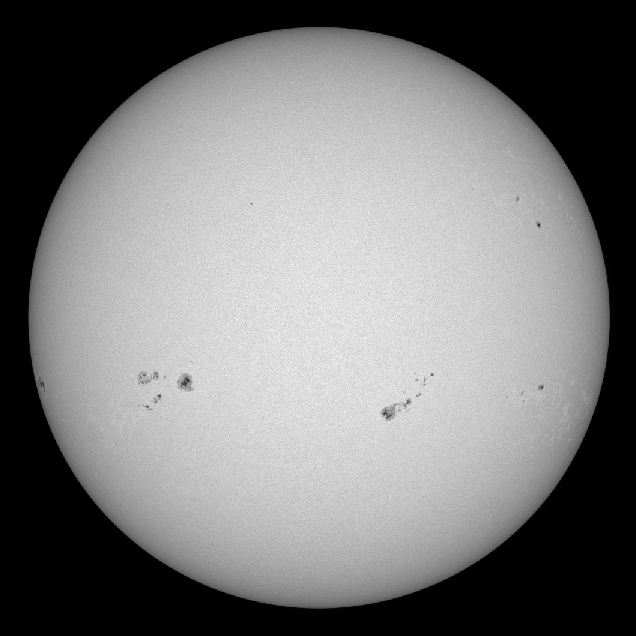

In [22]:
figure2 = plt.figure(len(sequences),figsize=(8,8))
def AnimationSunspots(i):
  #figure2 = plt.figure(len(sequences),figsize=(8,8))
  try:
    print(f"Animating frame:{i} of Total sequences:{len(sequences)}")
    smap = sunpy.map.Map(sequences[i])
    smap = smap.resample((1024,1024)*u.pix)
    smap = smap.rotate(order=3)
    axs2 = figure2.add_subplot(projection=smap)
    axs2.set_axis_off()
    smap.plot(axes=axs2,annotate=False)
  except:
    pass
animationResult = animation.FuncAnimation(figure2,AnimationSunspots,frames=len(files),interval=500,blit=False)
animationResult.save("/content/animationSunspotsImage.gif",writer="imagemagick",fps=25,dpi=800)
plt.show()

# Identify Sunpots

In [23]:
# if needed
colors = np.array(['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00'])
colors = np.append(colors,["#000000"])

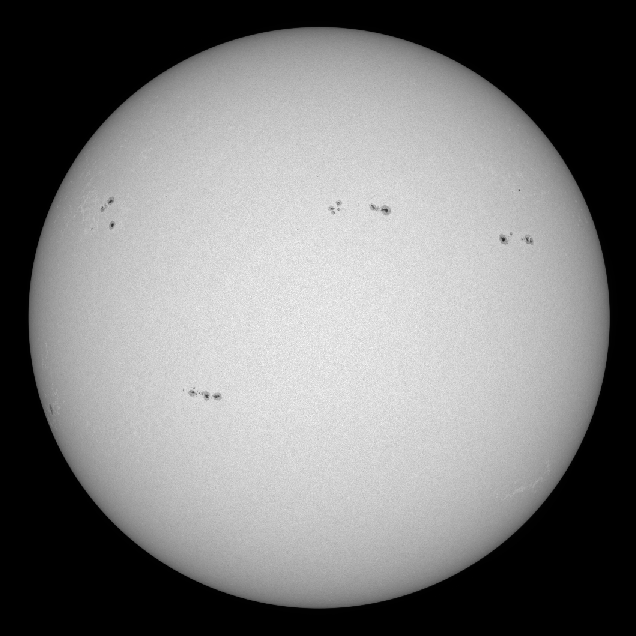

In [24]:
figure2 = plt.figure(len(sequences),figsize=(8,8))
smap = sunpy.map.Map(files[0])
smap = smap.resample((1024,1024)*u.pix)
smap = smap.rotate(order=3)
axs2 = figure2.add_subplot(111,projection=smap)
axs2.set_axis_off()
smap.plot(axes=axs2,annotate=False)
plt.show()

In [25]:
# returns True for all x,y positions on the image where there is a snunspot
sunspotBool = MorphologicalOperation(smap,limFilter=5*u.percent)
spots = np.where(sunspotBool)

In [26]:
spot2D = np.column_stack((spots[0],spots[1]))
cluster = DBSCAN(eps=5,min_samples=10).fit(spot2D)

In [27]:
labels = cluster.labels_

In [28]:
nCluster = len(set(labels))-(1 if -1 in labels else 0)
nCluster

11

In [29]:
nNoise = list(labels).count(-1)

In [30]:
nNoise

6

In [ ]:
spots2D = np.column_stack((spots[0],spots[1]))
clust = DBSCAN(eps=5,min_samples=10).fit(spots2D)
labels = clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
y_pred = clust.labels_.astype(int)

In [32]:
print(f"Estimated Number of Sunspots: {n_clusters_}")
print(f"Estimated Number of Noise Points: {n_noise_}")
print(f"Count of Prediciton: {len(y_pred)}")

Estimated Number of Sunspots: 11
Estimated Number of Noise Points: 6
Count of Prediciton: 1526


In [33]:
len(colors)

10

In [34]:
spot2DRot = 1024-spots2D

In [35]:
len(spot2DRot)

1526

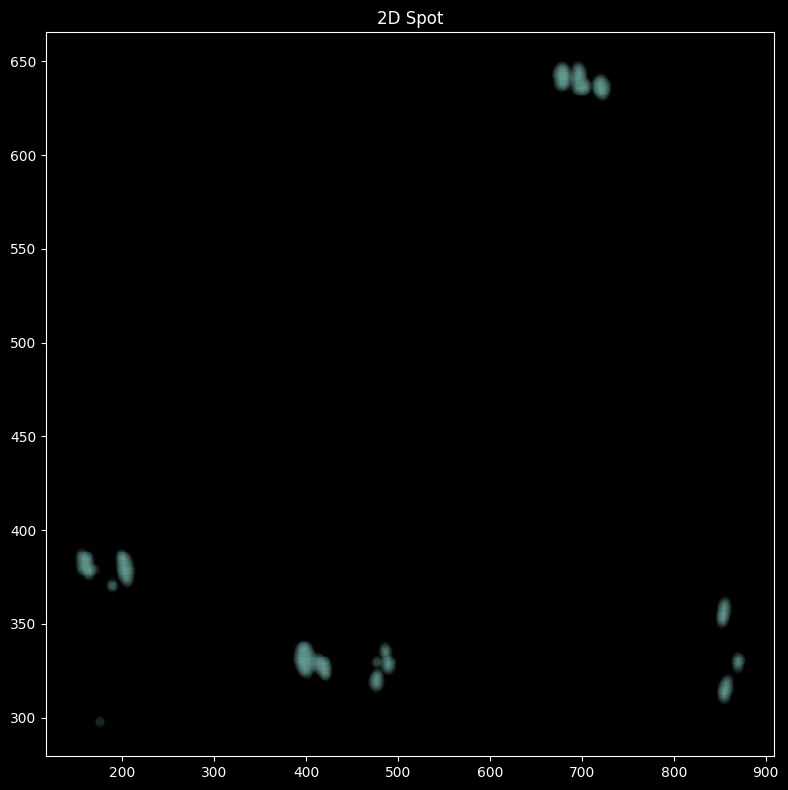

In [36]:
plt.figure(figsize=(8,8))
plt.title("2D Spot")
plt.scatter(spot2DRot[:,1],spot2DRot[:,0],s=30,alpha=0.03)
plt.tight_layout()
plt.show()

# Calculating Cluster Center

In [37]:
def CalculationClusterCenter(spots2DArray,predictions)->np.ndarray:
  clusterPoints = []
  spotStack = np.column_stack((spots2DArray,predictions))
  for index in set(predictions):
    clst = spotStack[np.ix_(spotStack[:,2]==index,(0,1))]
    numberCluster = len(clst)
    xPoint = np.sum(clst[:,0])/numberCluster
    yPoint = np.sum(clst[:,1])/numberCluster
    clusterPoints.append([xPoint,yPoint])
  return np.array(clusterPoints)

In [38]:
clusterPoints = CalculationClusterCenter(spots2D,y_pred)

In [39]:
clusterPointsRot = 1024-clusterPoints

In [40]:
len(clusterPointsRot)

12

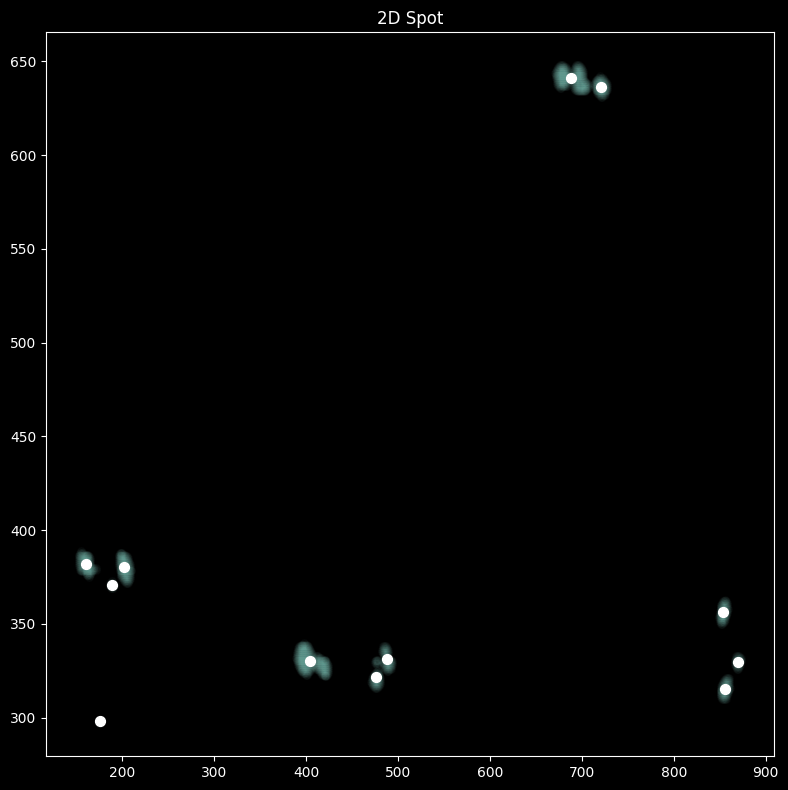

In [41]:
plt.figure(figsize=(8,8))
plt.title("2D Spot")
plt.scatter(spot2DRot[:,1],spot2DRot[:,0],s=30,alpha=0.03)
plt.scatter(clusterPointsRot[:,1],clusterPointsRot[:,0],color="white",s=50)
plt.tight_layout()
plt.show()

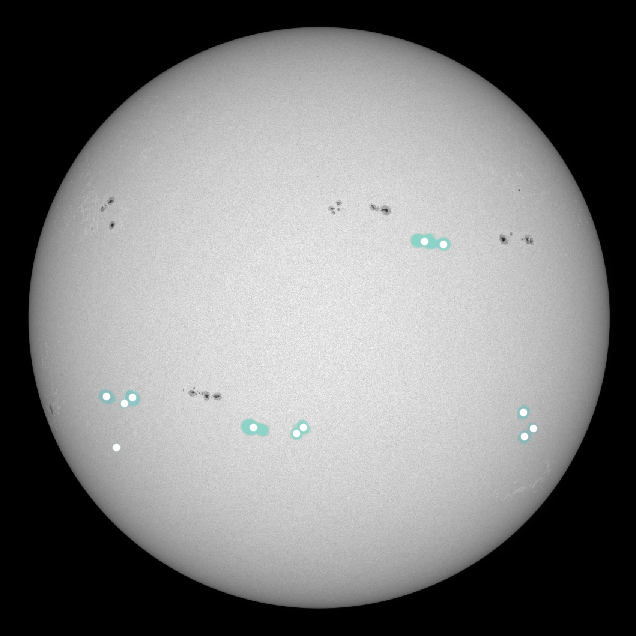

In [42]:
figure2 = plt.figure(len(sequences),figsize=(8,8))
smap = sunpy.map.Map(files[0])
smap = smap.resample((1024,1024)*u.pix)
smap = smap.rotate(order=3)
axs2 = figure2.add_subplot(111,projection=smap)
axs2.scatter(spot2DRot[:,1],spot2DRot[:,0],s=30,alpha=0.03)
axs2.scatter(clusterPointsRot[:,1],clusterPointsRot[:,0],color="white",s=20)
axs2.set_axis_off()
smap.plot(axes=axs2,annotate=False)
plt.show()